In [2]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import data_preprocessing as dp
import utilities
import models.training as train

In [3]:
data, events = dp.load_data(subjects=range(1,11))
data, events = dp.choose_condition(data, events, 'inner speech')

In [4]:
f_data = dp.filter_interval(data, [1,3.5],256)
rf_data = f_data.reshape(len(f_data), 128*640)

PCA on mean of all trials

In [25]:
mean_data = np.mean(f_data, axis = 0)
pca_mean = PCA(0.98)
pca_mean.fit(mean_data)
print(mean_data.shape)

(128, 640)


In [26]:
mean_temp = [pca_mean.transform(elem) for elem in f_data]
print(mean_temp[0].shape)

(128, 35)


In [27]:
inv_mean = [pca_mean.inverse_transform(elem) for elem in mean_temp]

In [46]:
def pca_pic(index):
    plt.figure(figsize= (4 ,3))
    plt.imshow(mean_temp[index].T)
    plt.title('PCA transposed')
    plt.show()
def side_by_side(indexes):
    org = f_data[indexes]
    rec = inv_mean[indexes]
    middle = np.zeros((128,20))
    pair = np.concatenate((org, middle), axis=1)
    pair = np.concatenate((pair, rec), axis=1)
    plt.figure(figsize=(10,8))
    plt.imshow(pair, cmap='viridis')
    plt.title('Before and after pca')
    plt.show()
def difference(indexes):
    org = f_data[indexes]
    rec = inv_mean[indexes]
    diff = org-rec
    plt.figure(figsize=(5,4))
    plt.imshow(diff)
    plt.title('Difference: Before- after')
    plt.show()

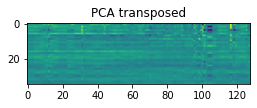

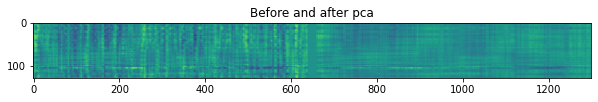

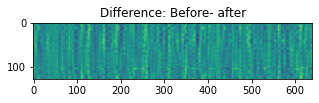

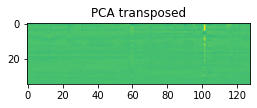

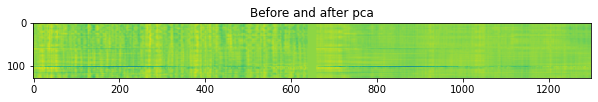

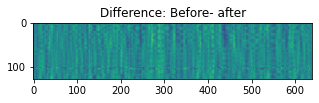

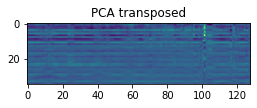

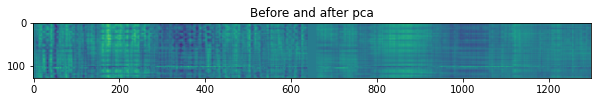

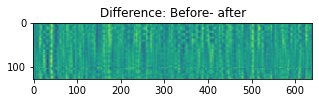

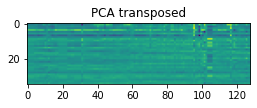

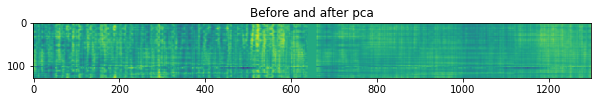

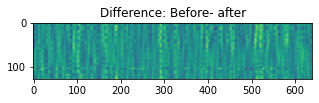

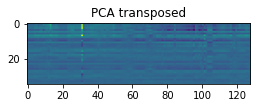

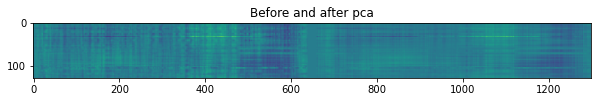

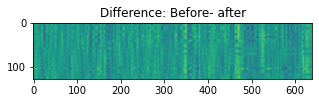

In [47]:
for elem in range(5):
    pca_pic(elem)
    side_by_side(elem)
    difference(elem)

Create dataset for Conv Network

In [48]:
m_dataset = tf.data.Dataset.from_tensor_slices((mean_temp, events[:, 1]))
m_dataset = dp.preprocessing_pipeline(
    m_dataset,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                lambda sample: (tf.reshape(sample[0],(*sample[0].shape, 1)), sample[1])],
    args = [[], []],
    batch_size = 12
)
m_datasets = dp.split_dataset(m_dataset)

In [49]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Activation, BatchNormalization, MaxPool2D

In [50]:
class ConvAuto2(Model):
    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(ConvAuto2, self).__init__()

        self.layer_list = [
            #Conv2D(filters=32, kernel_size=(3,3), padding = 'same'),
            #BatchNormalization(),
            #LeakyReLU(),
            #MaxPool2D(),
            Conv2D(filters=16, kernel_size=(3,3), padding = 'same'),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3),
            MaxPool2D(),
            Conv2D(filters=8, kernel_size=(3,3), padding = 'same'),
            BatchNormalization(),
            LeakyReLU(),
            tf.keras.layers.GlobalAveragePooling2D(),
            Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

In [52]:
model = ConvAuto2()
model.build((None, 128, 17, 1))
model.summary()

Model: "conv_auto2_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  160       
_________________________________________________________________
batch_normalization_2 (Batch multiple                  64        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    multiple                  0         
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  1160      
_________________________________________________________________
batch_normalization_3 (Batch multiple                 

In [53]:
%matplotlib tk
# Initialize the loss-function
loss_func = tf.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()
# Initialize Train-Object
trainer = train.Trainer(model, m_datasets,
                        optimizer, loss_func, train.accuracy)
# Initialize Plotting-Object
grapher = utilities.TrainingGrapher(3,1, supxlabel='Epochs', axs_xlabels=[['Train Loss', 'Test Loss', 'Test Accuracy']])


for epoch in range(10):
    print("Epoch:", epoch, end='\r')
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test'], trainer.accuracies['test']])

C:\Users\fkock\Documents\Master\Semester 2\Implementing ANNs with TensorFlow\inner_speech_decoding\utilities.py:75: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  self.axs[i%self.plot_shape[1], i//self.plot_shape[1]].set_xlim(min(xd), max(xd))


In [5]:
train_data = rf_data[:int(len(rf_data)*0.9)]

Standardizer. The standardizer is trained on the training data

In [6]:
scaler = StandardScaler()
scaler.fit(train_data)
strain_data = scaler.transform(train_data)
s_data = scaler.transform(rf_data)

PCA usually done with only train as well

Text(0, 0.5, 'Cumulative explained variance')

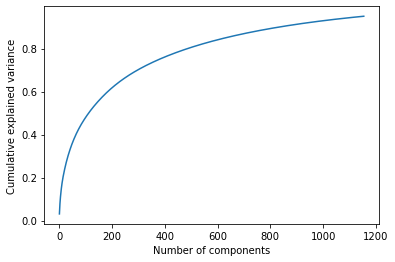

In [8]:
pca = PCA(n_components=0.95)
pca.fit(strain_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Text(0, 0.5, 'Cumulative explained variance')

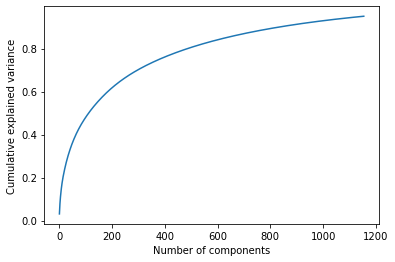

In [81]:
pca2 = PCA(0.95)
pca2.fit(s_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [82]:
temp = pca2.transform(s_data)

In [83]:
print(temp.shape)

(2076, 1254)


In [9]:
pca_train_data = pca.transform(strain_data)
pca_data = pca.transform(s_data)
print(strain_data.shape)
print(pca_data.shape)

(1868, 81920)
(2076, 1155)


In [10]:
inv_pca = pca.inverse_transform(pca_data)
inv_sc = scaler.inverse_transform(inv_pca)


In [11]:
def side_by_side(indexes):
    org = rf_data[indexes].reshape(128,640)
    rec = inv_sc[indexes].reshape(128,640)
    pair = np.concatenate((org, rec), axis=1)
    plt.figure(figsize=(10,8))
    plt.imshow(pair)
    plt.show()
def difference(indexes):
    org = rf_data[indexes].reshape(128,640)
    rec = inv_sc[indexes].reshape(128,640)
    diff = org-rec
    plt.figure(figsize=(5,4))
    plt.imshow(diff)
    plt.show()


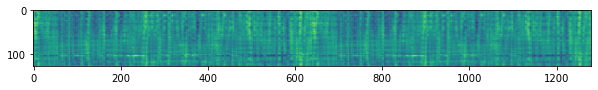

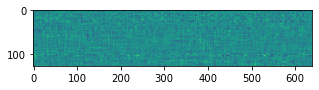

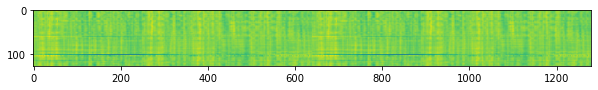

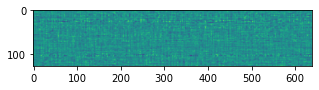

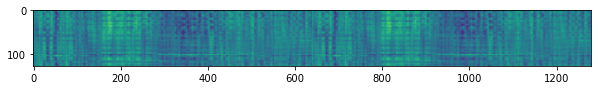

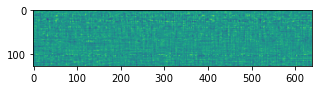

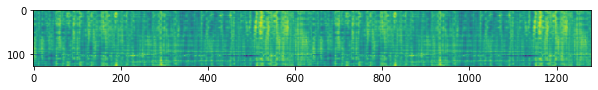

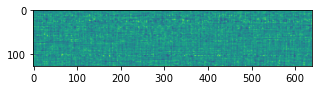

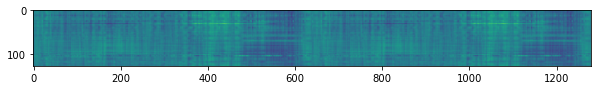

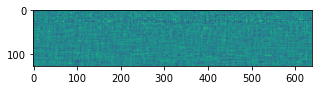

In [12]:
for index in range(0,5):
    side_by_side(index)
    difference(index)

Create tf.datasets

In [13]:
pca_comp = pca_data.shape[1]
print(pca_comp)

1155


In [14]:
dataset = tf.data.Dataset.from_tensor_slices((pca_data, events[:, 1]))
dataset = dp.preprocessing_pipeline(
    dataset,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                 lambda sample: (tf.reshape(sample[0], (pca_comp, 1, 1)),
                                 sample[1])],
    args = [[], []],
    batch_size = 12
)

In [15]:
# split dataset
datasets = dp.split_dataset(dataset)

In [47]:

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import Dense, Dropout, GaussianNoise, Conv1D, LeakyReLU, MaxPool1D, Flatten
from keras.preprocessing.image import ImageDataGenerator

In [48]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)
labels = onehot_encoder.fit_transform(events[:,1].reshape(-1, 1))


In [106]:
model = Sequential()
layers = 2
pca_std = np.std(pca_train_data)

model.add(Dense(32, activation='sigmoid'))
model.add(GaussianNoise(pca_std))
model.add(Dropout(0.1))
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(GaussianNoise(pca_std))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

history = model.fit(temp, labels, epochs=20, batch_size=10, validation_split=0.1, verbose=1)

Epoch 1/20
187/187 [==============================] - 1s 4ms/step - loss: 10.6869 - categorical_accuracy: 0.2505 - val_loss: 1.4339 - val_categorical_accuracy: 0.2308
Epoch 2/20
187/187 [==============================] - 0s 1ms/step - loss: 7.2022 - categorical_accuracy: 0.2527 - val_loss: 1.4027 - val_categorical_accuracy: 0.2452
Epoch 3/20
187/187 [==============================] - 0s 1ms/step - loss: 4.4761 - categorical_accuracy: 0.2398 - val_loss: 1.4038 - val_categorical_accuracy: 0.2452
Epoch 4/20
187/187 [==============================] - 0s 1ms/step - loss: 2.5450 - categorical_accuracy: 0.2693 - val_loss: 1.4060 - val_categorical_accuracy: 0.2452
Epoch 5/20
187/187 [==============================] - 0s 1ms/step - loss: 1.6422 - categorical_accuracy: 0.2484 - val_loss: 1.3996 - val_categorical_accuracy: 0.2452
Epoch 6/20
187/187 [==============================] - 0s 1ms/step - loss: 1.4171 - categorical_accuracy: 0.2543 - val_loss: 1.3974 - val_categorical_accuracy: 0.2452
Epo

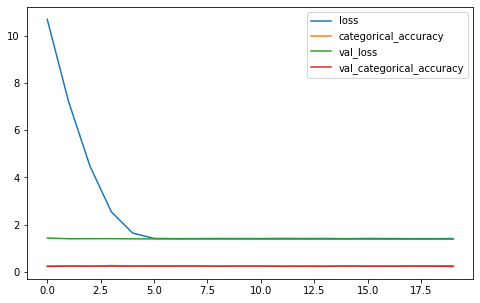

In [107]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()